Titles:

- Don't use a single train-test split with Time Series.
- Time Series Cross-Validation for fun and profit.
- Turn 80& of time series your data into a test.
- 



In [1]:
# import pandas as pd
# from fold import train_evaluate, ExpandingWindowSplitter, SingleWindowSplitter, Backend
from fold.utils.tests import generate_sine_wave_data
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import ray
from krisi.report.vizualise import plot_y_predictions

no_of_observation_per_day = 24

no_of_observation_per_week = no_of_observation_per_day * 7

# X, y = get_preprocessed_dataset(
#     "energy/industrial_pv_load",
#     target_col="residual_load",
#     resample="H",
#     deduplication_strategy="first",
#     shorten=10000,
# )

X, y = generate_sine_wave_data()
# ray.init(ignore_reinit_error=True)

## What's in our data?

We sourced it from [Kaggle](https://www.kaggle.com/competitions/energy-forecasting-data-challenge):

`
"In order to ensure a stable energy supply, the energy suppliers rely on forecasts of these residual loads. In the past, those residual loads could be forecast based on many years of experience. Now, the share of solar energy systems and therefore the amount of energy self-generation increases more and more. This makes forecasting the residual loads more and more complex as there are dependencies on external factors like the weather. However, the forecast is necessary to maintain a proper supply operation. For this reason, it is essential to have a forecast of the residual load that is as accurate as possible."
`

Let's have a look at our target variable, and the auto-correlation plot!

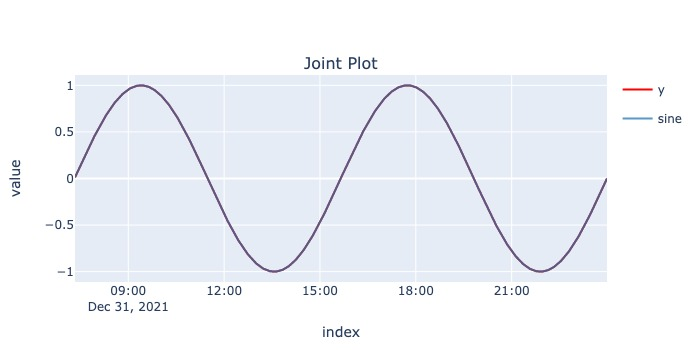

In [2]:
# y.plot(figsize = (20,5), grid=True);

plot_y_predictions(y, y)

In [ ]:
plot_acf(y, lags=no_of_observation_per_week);

1. There's high auto-correlation going on.
The energy consumption of the next hour won't change dramatically, compared to the last'.

2. There's a strong daily seasonality.
Also makes sense! The yesterday's 4pm reading can be pretty indicative of next day's.

3. There's a slight weekly seasonality.
Weekends can be quite in a factory, while weekdays are pretty "full on"!

## Training our first model, blindly!

Now let's do something every time series tutorial will start with:
Let's fit "Prophet" on 70% of the dataset, and try to predict the next 30%! (But, don't close this article just yet;)

In [ ]:
from fold_models import WrapProphet
from prophet import Prophet
from fold import train_evaluate
splitter = SingleWindowSplitter(train_window=0.7)
pipeline = WrapProphet.from_model(Prophet(yearly_seasonality=False)) # you can try True as well, it'll look even more weird

score, preds, pipelines_over_time = train_evaluate(pipeline, X, y, splitter)
score.print_summary(extended=False)
plot_y_and_predictions(y, preds)

Looks pretty silly. We don't really have a lot of data, and the model couldn't pick up the slow-moving yearly sesaonal trend based on a single example.

## Enter Time Series Cross-Validation

But, is our evaluation methodology any good?
We used more than 1 years of data, and tried to predict the next 4 months. In reality, it's more likely that our business wants to see 1 week or 1 month ahead, and we have a chance to update our model as new data comes in.

**When working on Time Series data, you don't need to use only a single test split.**
You can train as many models are there are weeks/months in your data, and let the specific models predict the next week's data.

All in all, let's get this model to predict for 16 out of the 19 months we have data for!

Since now we're training 16 models, instead of one, let's try to paralellize the computation by using [ray](https://www.ray.io/) as a backend.

In [ ]:
expanding_splitter = ExpandingWindowSplitter(initial_train_window=no_of_observation_per_week * 12, step=no_of_observation_per_week * 4)
pipeline = WrapProphet.from_model(Prophet())

score, preds, pipelines_over_time = train_evaluate(pipeline, X, y, expanding_splitter, backend=Backend.ray)
score.print_summary(extended=False)
plot_y_and_predictions(y, preds)

When we re-train our model 16 times - as we move through time -, we see that the quality of predictions throughout the time series are also substantially different.
Why?

**Re-training every month helps the model to detect when the yearly trend is changing, on the fly, without needing years worth of data.**

With Time Series Cross-Validation, we can be a lot more certain that our test set is representative, and that our model will perform as we expect them to, out-of-sample.

## But is Prophet really that good?

But, coming back to the model: it's really hard to tell if "Prophet" is appropriate for our usecase, if we don't look at alternatives!

Let's try a "Seasonal Naive" model, that just repeats the last day's values for the next day. 

  0%|          | 0/12 [00:00<?, ?it/s]

Mean Absolute Error - 53.805         
          Mean Absolute Percentage Error - 1.2126         
Symmetric Mean Absolute Percentage Error - 0.21936        
                      Mean Squared Error - 1.0695e+04     
                 Root Mean Squared Error - 103.42         
                               R-squared - 0.50398        
                   Mean of the Residuals - 0.49139        
     Standard Deviation of the Residuals - 103.42

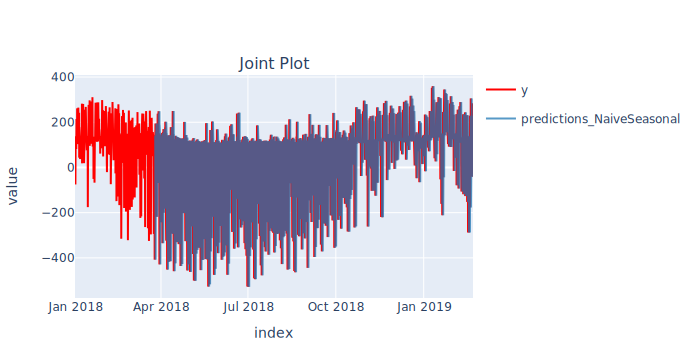

In [10]:
from fold_models import NaiveSeasonal
expanding_splitter = ExpandingWindowSplitter(initial_train_window=no_of_observation_per_week * 12, step=no_of_observation_per_week * 4)
pipeline = NaiveSeasonal(no_of_observation_per_day)

score, preds, pipelines_over_time = train_evaluate(pipeline, X, y, expanding_splitter, backend=Backend.ray)
score.print('minimal')
plot_y_predictions(y, preds)

Surprisingly, the repeating the last day's values beats Prophet - how is that possible?

Well, Prophet definitely does not know what the last day's value were, while the NaiveSeasonal model will have access to this information - it's actually updated on every timestamp.

Can we take advantage of the "online" nature of the Naive models, and  get even greater performance by just repeating the reading of the last hour?

In [ ]:
from fold_models import Naive
expanding_splitter = ExpandingWindowSplitter(initial_train_window=no_of_observation_per_week * 12, step=no_of_observation_per_week * 4)
pipeline = Naive()

score, preds, pipelines_over_time = train_evaluate(pipeline, X, y, expanding_splitter, backend=Backend.ray)
score.print_summary(extended=False)
plot_y_and_predictions(y, preds)

It looks like we can, having access to the residual load of the last hour beats any kind of long-term forecast.

(This may not be a huge surprise if we look at the original autocorrelation plot, and observe that the correllation coefficient between the last value and the next is above 0.9!)

## Last chance for Prophet

**Now, let's give Prophet a fair chance, and re-train it every week!**
If we see our metrics improving, we could even try to re-train it more frequently! Warning: this may take some time.

In [ ]:
expanding_splitter = ExpandingWindowSplitter(initial_train_window=no_of_observation_per_week * 12, step=no_of_observation_per_week)
pipeline = WrapProphet.from_model(Prophet())

score, preds, pipelines_over_time = train_evaluate(pipeline, X, y, expanding_splitter, backend=Backend.ray)
score.print_summary(extended=False)
plot_y_and_predictions(y, preds)

It looks like when re-training the model weekly (rather than monthly), we can model the slower-moving trend slightly better. Our metrics haven't changed much: the general capability of our model did not improve.

If we are patient enough, we could repeat this exercise and train a different Prophet model for every day, but I'd not expect a considerable change in performance, and we could try out more appropriate models. 

# Why use Time Series Cross-Validation then?

All in all, using Time Series Cross-Validation for model selection (over traditional single train-test split) can be extremely useful.

It really shines when:

1. The time-series you want to model is **contains multiple different regimes**, like all financial data. You don't want to select a model based on a single regime's performance - it will probably not end well when the regime changes.

2. **You don't have a lot of data**. You can really turn the vast majority (80-90%) of your data into out-of-sample test set(s). You need to be careful, as always not to "overfit" on out-of-sample data, but we're developing easy-to-use tooling for model selection, that's coming to `fold` in the next month.

3. You closely want to **simulate how a model could have performed in production on past data**, as it is constantly re-trained with new data coming in.
You really don't need to ignore time, pretend that your models are static - can't be updated -, and there's no chance they can adapt to the ever-changing, complex world we live in.
They can adapt!
